---
title: iCOM SSNR  
authors: [Julie Marie Bekkevold, Georgios Varnavides]  
date: 2025-05-12  
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import ctf # import custom plotting / utils
import cmasher as cmr 
import tqdm

from scipy.ndimage import gaussian_filter

In [2]:
# parameters
n = 96
q_max = 2 # inverse Angstroms
q_probe = 1 # inverse Angstroms
wavelength = 0.019687 # 300kV
sampling = 1 / q_max / 2 # Angstroms
reciprocal_sampling = 2 * q_max / n # inverse Angstroms

scan_step_size = 1 # pixels
sx = sy = n//scan_step_size
phi0 = 1.0
C10 = 0

cmap = cmr.eclipse
segmented_icom_line_color = 'cornflowerblue'
pixelated_icom_line_color = 'midnightblue'

In [3]:
def white_noise_object_2D(n, phi0):
    """ creates a 2D real-valued array, whose FFT has random phase and constant amplitude """

    evenQ = n%2 == 0
    
    # indices
    pos_ind = np.arange(1,(n if evenQ else n+1)//2)
    neg_ind = np.flip(np.arange(n//2+1,n))

    # random phase
    arr = np.random.randn(n,n)
    
    # top-left // bottom-right
    arr[pos_ind[:,None],pos_ind[None,:]] = -arr[neg_ind[:,None],neg_ind[None,:]]
    # bottom-left // top-right
    arr[pos_ind[:,None],neg_ind[None,:]] = -arr[neg_ind[:,None],pos_ind[None,:]]
    # kx=0
    arr[0,pos_ind] = -arr[0,neg_ind]
    # ky=0
    arr[pos_ind,0] = -arr[neg_ind,0]

    # zero-out components which don't have k-> -k mapping
    if evenQ:
        arr[n//2,:] = 0 # zero highest spatial freq
        arr[:,n//2] = 0 # zero highest spatial freq

    arr[0,0] = 0 # DC component

    # fourier-array
    arr = np.exp(2j*np.pi*arr)*phi0

    # inverse FFT and remove floating point errors
    arr = np.fft.ifft2(arr).real
    
    return arr

# potential
potential = white_noise_object_2D(n,phi0)
complex_obj = np.exp(1j*potential)

In [4]:
# we build probe in Fourier space, using a soft aperture

qx = qy = np.fft.fftfreq(n,sampling)
q2 = qx[:,None]**2 + qy[None,:]**2
q  = np.sqrt(q2)

x = y = np.arange(0.,n,scan_step_size)
xx, yy = np.meshgrid(x,y,indexing='ij')
positions = np.stack((xx.ravel(),yy.ravel()),axis=-1)
row, col = ctf.return_patch_indices(positions,(n,n),(n,n))

In [5]:
probe_array_fourier_0 = np.sqrt(
    np.clip(
        (q_probe - q)/reciprocal_sampling + 0.5,
        0,
        1,
    ),
)

def simulate_intensities(C10):
    probe_array_fourier = probe_array_fourier_0 * np.exp(-1j * np.pi * wavelength * q**2 * C10)
    
    # normalized s.t. np.sum(np.abs(probe_array_fourier)**2) = 1.0
    probe_array_fourier /= np.sqrt(np.sum(np.abs(probe_array_fourier)**2))
    
    # we then take the inverse FFT, and normalize s.t. np.sum(np.abs(probe_array)**2) = 1.0
    probe_array = np.fft.ifft2(probe_array_fourier) * n
    
    
    intensities = ctf.simulate_data(
        complex_obj,
        probe_array,
        row,
        col,
    ).reshape((sx,sy,n,n))**2 / n**2
    
    return intensities, probe_array_fourier

ints, probe = simulate_intensities(C10=C10)

In [6]:
# Spatial frequencies
kx = ky = np.fft.fftfreq(n,sampling).astype(np.float32)
kxa, kya = np.meshgrid(kx, ky, indexing='ij')

k2 = kxa**2 + kya**2
k = np.sqrt(k2)
k2[0, 0] = np.inf

# iCoM operators
kx_op = -1.0j * kxa / k2
ky_op = -1.0j * kya / k2

def compute_icom(
    intensities,
):
    """ """
    ints_sums = intensities.sum((-1,-2))
    com_x = np.sum(intensities * kxa,axis=(-1,-2)) / ints_sums
    com_y = np.sum(intensities * kya,axis=(-1,-2)) / ints_sums

    icom = np.real(np.fft.ifft2(np.fft.fft2(com_x)*kx_op + np.fft.fft2(com_y)*ky_op))

    return icom

In [7]:
def annular_segmented_detectors(
    gpts,
    sampling,
    n_angular_bins,
    rotation_offset = 0,
    inner_radius = 0,
    outer_radius = np.inf,
):
    """ """
    nx,ny = gpts
    sx,sy = sampling

    k_x = np.fft.fftfreq(nx,sx)
    k_y = np.fft.fftfreq(ny,sy)

    k = np.sqrt(k_x[:,None]**2 + k_y[None,:]**2)
    radial_mask = ((inner_radius <= k) & (k < outer_radius))
    
    theta = (np.arctan2(k_y[None,:], k_x[:,None]) + rotation_offset) % (2 * np.pi)
    angular_bins = np.floor(n_angular_bins * (theta / (2 * np.pi))) + 1
    angular_bins *= radial_mask.astype("int")

    angular_bins = [np.fft.fftshift((angular_bins == i).astype("int")) for i in range(1,n_angular_bins+1)]
    
    return angular_bins

def compute_com_using_virtual_detectors(
    corner_centered_intensities,
    center_centered_masks,
    kxa,kya,
):
    """ """
    corner_centered_intensities_sum = corner_centered_intensities.sum((-1,-2))
    masks = np.fft.ifftshift(np.asarray(center_centered_masks),axes=(-1,-2))

    sx,sy = corner_centered_intensities.shape[:2]
    com_x = np.zeros((sx,sy))
    com_y = np.zeros((sx,sy))
    
    for mask in masks:
        kxa_i,kya_i=np.where(mask)
        patches= corner_centered_intensities[:,:,kxa_i,kya_i].sum(-1) / corner_centered_intensities_sum
        com_x += patches * np.mean(kxa[kxa_i,kya_i])
        com_y += patches * np.mean(kya[kxa_i,kya_i])
        
    return com_x, com_y

def compute_icom_segmented(
    intensities,
    center_centered_masks,
):
    """ """
    com_x, com_y = compute_com_using_virtual_detectors(
        intensities,
        center_centered_masks,
        kxa,kya,
    )

    icom = np.real(np.fft.ifft2(np.fft.fft2(com_x)*kx_op + np.fft.fft2(com_y)*ky_op))

    return icom

In [8]:
def compute_finite_icom(
    intensities,
    num_electrons_per_probe,
):
    """ """
    finite_ints = np.random.poisson(
        intensities * num_electrons_per_probe,
    )
    finite_ints_sums = finite_ints.sum((-1,-2))
    finite_com_x = np.sum(finite_ints * kxa,axis=(-1,-2)) / finite_ints_sums
    finite_com_y = np.sum(finite_ints * kya,axis=(-1,-2)) / finite_ints_sums

    finite_icom = np.real(np.fft.ifft2(np.fft.fft2(finite_com_x)*kx_op + np.fft.fft2(finite_com_y)*ky_op))

    return finite_icom

def compute_finite_icom_segmented(
    intensities,
    num_electrons_per_probe,
    center_centered_masks,
):
    """ """
    finite_ints = np.random.poisson(
        intensities * num_electrons_per_probe,
    )
    finite_com_x, finite_com_y = compute_com_using_virtual_detectors(
        finite_ints,
        center_centered_masks,
        kxa,kya,
    )

    finite_icom = np.real(np.fft.ifft2(np.fft.fft2(finite_com_x)*kx_op + np.fft.fft2(finite_com_y)*ky_op))

    return finite_icom

In [9]:
num_draws = 256
num_electrons_per_probe = 1e8

array([[[0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        ...,
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29]],

       [[0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        ...,
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29]],

       [[0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        ...,
        [0.00000000e+00, 1.85838121e-27, 9.23185916e-29],
        [0.00000000e+00, 1.85

In [10]:
virtual_masks_annular = annular_segmented_detectors(
    gpts=(n,n),
    sampling=(sampling,sampling),
    n_angular_bins=4,
    inner_radius=0.5*q_probe,
    outer_radius=1.05*q_probe,
    rotation_offset=0,
)

In [11]:
finite_icoms = np.empty((num_draws,n,n),dtype=np.float32)

for i in tqdm.trange(num_draws):
    finite_icoms[i] = compute_finite_icom(
        ints,
        num_electrons_per_probe
    )

100%|██████████████████████████████████████████████████████████████████████████████████████| 256/256 [11:30<00:00,  2.70s/it]


In [12]:
finite_icoms_annular = np.empty((num_draws,n,n),dtype=np.float32)

for i in tqdm.trange(num_draws):
    finite_icoms_annular[i] = compute_finite_icom_segmented(
        ints,
        num_electrons_per_probe,
        virtual_masks_annular
    )

100%|██████████████████████████████████████████████████████████████████████████████████████| 256/256 [16:20<00:00,  3.83s/it]


In [13]:
def spectral_snr(ctf_arrays, radial_average=False):
    """ """ 
    abs_mean = np.abs(ctf_arrays.mean(0))
    std_ddof_1 = ctf_arrays.std(0,ddof=1)
    if radial_average:
        _, abs_mean = ctf.radially_average_ctf(abs_mean,sampling=(sampling,sampling))
        _, std_ddof_1 = ctf.radially_average_ctf(std_ddof_1,sampling=(sampling,sampling))
        
    return abs_mean/std_ddof_1

In [14]:
mask = (k <= q_max).astype(np.float32)
finite_icoms_fft = np.fft.fft2(finite_icoms)
signal_icoms = np.abs(finite_icoms_fft.mean(0))
noise_icoms = finite_icoms_fft.std(0,ddof=1) * mask * np.sqrt(num_electrons_per_probe) / n * 2
noise_icoms[noise_icoms<1e-4] = np.inf
inverse_noise_icoms = 1/noise_icoms

q_bins_inverse_noise, I_bins_inverse_noise = ctf.radially_average_ctf(inverse_noise_icoms,(sampling,sampling))
q_bins_signal, I_bins_signal = ctf.radially_average_ctf(signal_icoms,(sampling,sampling))

In [15]:
finite_icoms_annular_fft = np.fft.fft2(finite_icoms_annular)
signal_icoms_annular = np.abs(finite_icoms_annular_fft.mean(0))
noise_icoms_annular = finite_icoms_annular_fft.std(0,ddof=1) * mask * np.sqrt(num_electrons_per_probe) / n * 2
noise_icoms_annular[noise_icoms_annular<1e-4] = np.inf
inverse_noise_icoms_annular = 1/noise_icoms_annular

q_bins_inverse_noise_annular, I_bins_inverse_noise_annular = ctf.radially_average_ctf(inverse_noise_icoms_annular,(sampling,sampling))
q_bins_signal_annular, I_bins_signal_annular = ctf.radially_average_ctf(signal_icoms_annular,(sampling,sampling))

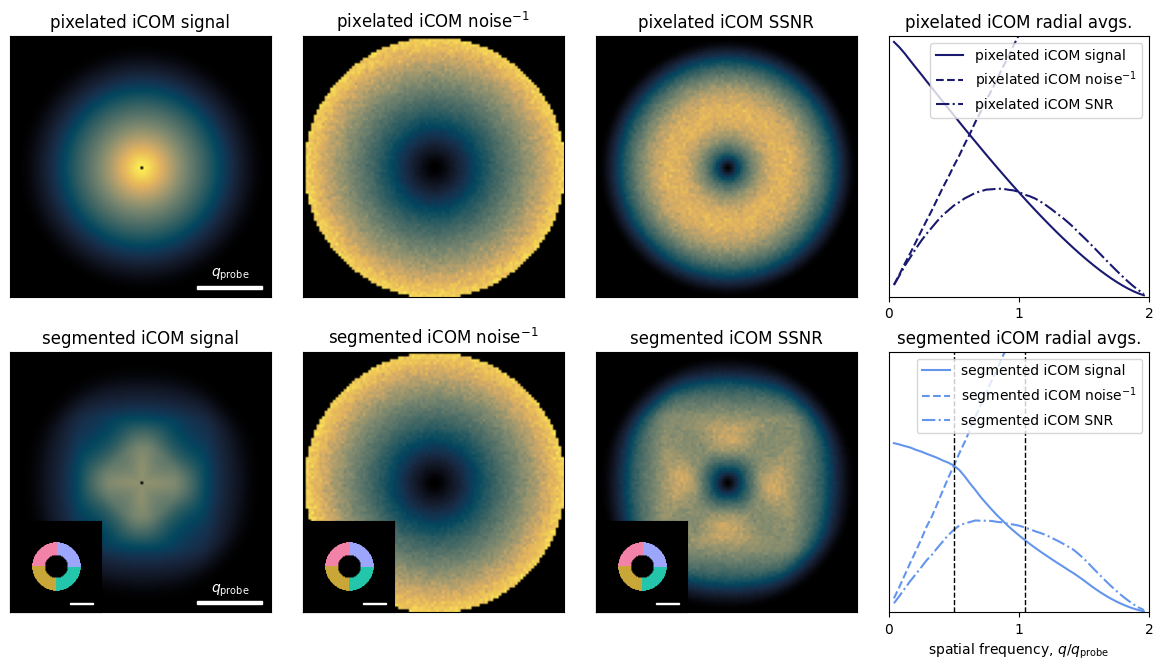

In [31]:
fig, axs = plt.subplots(2,4,figsize=(12,6.75))

axs[0,0].imshow(
    np.fft.fftshift(signal_icoms),
    cmap=cmap,
    vmin=0,
    vmax=1,
)

axs[0,1].imshow(
    np.fft.fftshift(inverse_noise_icoms),
    cmap=cmap,
)

axs[0,2].imshow(
    np.fft.fftshift(signal_icoms*inverse_noise_icoms),
    cmap=cmap,
    vmin=0,
    vmax=1/2,
)

axs[0,3].plot(
    q_bins_signal[1:-1],
    I_bins_signal[1:-1],
    color=pixelated_icom_line_color,
    label='pixelated iCOM signal'
)

axs[0,3].plot(
    q_bins_inverse_noise[1:-1],
    I_bins_inverse_noise[1:-1],
    color=pixelated_icom_line_color,
    linestyle='--',
    label=r'pixelated iCOM noise$^{-1}$'
)

axs[0,3].plot(
    q_bins_inverse_noise[1:-1],
    I_bins_inverse_noise[1:-1] * I_bins_signal[1:-1],
    color=pixelated_icom_line_color,
    linestyle='-.',
    label='pixelated iCOM SNR'
)
axs[0,3].set(
    xlim=[0,2],
    ylim=[0,1],
    xticks=[0,q_probe,q_max],
    xticklabels=[0,1,2],
    aspect=2,
    title='pixelated iCOM radial avgs.',
    yticks=[]
)
axs[0,3].legend()

axs[1,0].imshow(
    np.fft.fftshift(signal_icoms_annular),
    cmap=cmap,
    vmin=0,
    vmax=1,
)

axs[1,1].imshow(
    np.fft.fftshift(inverse_noise_icoms_annular),
    cmap=cmap,
)

axs[1,2].imshow(
    np.fft.fftshift(signal_icoms_annular*inverse_noise_icoms_annular),
    cmap=cmap,
    vmin=0,
    vmax=1/2,
)

for ax in axs[1,:3]:
    ax_in = ax.inset_axes(
        [0.0,0.0,0.35,0.35],
    )
    ax_in.imshow(ctf.combined_images_rgb(virtual_masks_annular))
    ax_in.set(xticks=[],yticks=[])
    ctf.add_scalebar(ax_in,length=n//4,sampling=reciprocal_sampling,units='')

axs[1,3].plot(
    q_bins_signal_annular[1:-1],
    I_bins_signal_annular[1:-1],
    color=segmented_icom_line_color,
    label='segmented iCOM signal'
)

axs[1,3].plot(
    q_bins_inverse_noise_annular[1:-1],
    I_bins_inverse_noise_annular[1:-1],
    color=segmented_icom_line_color,
    linestyle='--',
    label=r'segmented iCOM noise$^{-1}$'
)

axs[1,3].plot(
    q_bins_inverse_noise_annular[1:-1],
    I_bins_inverse_noise_annular[1:-1] * I_bins_signal_annular[1:-1],
    color=segmented_icom_line_color,
    linestyle='-.',
    label='segmented iCOM SNR'
)
axs[1,3].set(
    xlim=[0,2],
    ylim=[0,1],
    xticks=[0,q_probe,q_max],
    xticklabels=[0,1,2],
    aspect=2,
    xlabel=r"spatial frequency, $q/q_{\mathrm{probe}}$",
    title='segmented iCOM radial avgs.',
    yticks=[]
)
axs[1,3].legend()
axs[1,3].vlines([q_probe/2,q_probe*1.05],0,2,colors='k',linestyles='--',linewidth=1,)

titles = [
    "pixelated iCOM signal",r"pixelated iCOM noise$^{-1}$","pixelated iCOM SSNR",
    "segmented iCOM signal",r"segmented iCOM noise$^{-1}$","segmented iCOM SSNR"
]
for ax in axs[:,0]:
    ctf.add_scalebar(ax,length=n//4,sampling=reciprocal_sampling,units=r'$q_{\mathrm{probe}}$')

for ax, title in zip(axs[:,:3].ravel(),titles):
    ax.set(xticks=[],yticks=[],title=title)

fig.tight_layout()

In [32]:
fig.savefig("static_icom_ssnr_placeholder.png",bbox_inches='tight')